In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2

In [4]:
def format_yolov5(source):

    # put the image in square big enough
    col, row, _ = source.shape
    _max = max(col, row)
    resized = np.zeros((_max, _max, 3), np.uint8)
    resized[0:col, 0:row] = source
    
    # resize to 640x640, normalize to [0,1[ and swap Red and Blue channels
    result = cv2.dnn.blobFromImage(resized, 1/255.0, (640, 640), swapRB=True)
    
    return result

def unwrap_detection(input_image, output_data):
    class_ids = []
    confidences = []
    boxes = []

    rows = output_data.shape[0]

    image_width, image_height, _ = input_image.shape

    x_factor = image_width / 640 + abs(image_width - image_height) / 640
    y_factor =  image_height / 640

    for r in range(rows):
        row = output_data[r]
        confidence = row[4]
        if confidence >= 0.4:

            classes_scores = row[5:]
            _, _, _, max_indx = cv2.minMaxLoc(classes_scores)
            class_id = max_indx[1]
            if (classes_scores[class_id] > .25):

                confidences.append(confidence)

                class_ids.append(class_id)

                x, y, w, h = row[0].item(), row[1].item(), row[2].item(), row[3].item() 
                left = int((x - 0.5 * w) * x_factor)
                top = int((y - 0.5 * h) * y_factor)
                width = int(w * x_factor)
                height = int(h * y_factor)
                box = np.array([left, top, width, height])
                boxes.append(box)

    return class_ids, confidences, boxes

In [26]:
def get_ncars(model, frame, labels, draw=False):
    target_labels = ['car', 'truck', 'bus', 'motorbike']
    blob = format_yolov5(frame)
    model.setInput(blob)
    outputs = model.forward()[0]
    class_ids, confidences, boxes = unwrap_detection(frame, outputs)
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.25, 0.45)
    
    result_class_ids = []
    result_confidences = []
    result_boxes = []

    for i in indexes:
        result_confidences.append(confidences[i])
        result_class_ids.append(class_ids[i])
        result_boxes.append(boxes[i])
        
    n_cars = 0
    for i, class_id in enumerate(result_class_ids):
        if labels[class_id] in target_labels:
            n_cars+=1
    
        if draw:
            colors = [(255, 255, 0), (0, 255, 0), (0, 255, 255), (255, 0, 0)]
            box = result_boxes[i]
            class_id = result_class_ids[i]
            if labels[class_id] in target_labels:
                color = colors[class_id % len(colors)]

                conf  = result_confidences[i]

                cv2.rectangle(frame, box, color, 2)
                cv2.rectangle(frame, (box[0], box[1] - 20), (box[0] + box[2], box[1]), color, -1)
                cv2.putText(frame, labels[class_id], (box[0] + 5, box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0))
    return n_cars

In [27]:
cap = cv2.VideoCapture('vids/light1.mp4')
labels = open('names').read().splitlines()
model = cv2.dnn.readNet('yolov5s(1).onnx')
img = plt.imread('./check.jpg')
# n_cars = []
# while(cap.isOpened()):
#     ret, frame = cap.read()
#     if ret == True:
#         n_cars.append(get_ncars(model, frame, labels, draw=True))
#         if cv2.waitKey(25) & 0xFF == ord('q'):
#             break
#     else:
#         break

In [28]:
%time get_ncars(model, img, labels, draw='True')

CPU times: user 4.55 s, sys: 269 ms, total: 4.82 s
Wall time: 1.08 s


5

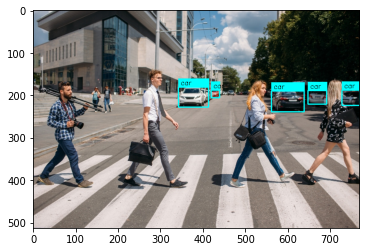

In [29]:
plt.imshow(img)